Today I found and removed another `rank()` check that was running once per line. This should translate to a further speedup in code execution. Let's test it:

In [1]:
# Data loading and manipulation:
using HDF5, JLD
include("../src/tmp_inst_rts96.jl")

# Analysis:
include("../src/TemporalInstanton.jl")
using TemporalInstanton

In [4]:
####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

Sb = 100e6 #overwrite "100.0"

res = r
reac = x

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
lines = [(f[i],t[i]) for i in 1:length(f)];
line_lengths = load("../data/RTS-96\ Data/line_lengths.jld", "line_lengths")

# Thermal model parameters:
Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps
int_length = 600. # seconds

println("loaded")

loaded


In [5]:
# time_intervals = 3 # thirty minutes
# time_values = 0:60:600 # ten minutes in 1-min steps
# int_length = 600. # seconds

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min

# Generation, demand, and wind gen forecast:
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

# G0 = [0.7*Gp;0.7*Gp;0.7*Gp]
# D0 = [0.9*Dp;0.9*Dp;0.9*Dp]
# P0 = [Rp;1.5*Rp;1.5*Rp]

# Temporal instanton analysis:
# score,x,θ,α,diffs,xopt = solve_temporal_instanton(
#     Ridx,Y,G0,P0,D0,Sb,ref,lines,
#     res,reac,k,line_lengths,Tamb,
#     T0,int_length)
# println("Unsolved lines: $(sum(score.==Inf))")

438-element Array{Float64,1}:
 0.0      
 0.0820657
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 ⋮        
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      

In [8]:
# Temporal instanton analysis:
score,x,θ,α,diffs,xopt = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,Tamb,
    T0,int_length)
println("Unsolved lines: $(sum(score.==Inf))")

Progress: 100% Time: 0:00:15
Unsolved lines: 0


The three-run average is now 14 seconds! It was nearly double that before this cleanup. Let's make sure the results still look good (sanity check):

In [1]:
# Plotting:
using Interact
using PyPlot
PyPlot.svg(true)

INFO: Loading help data...


true

In [9]:
include("../src/PowerFlow.jl")

return_angle_diffs (generic function with 1 method)

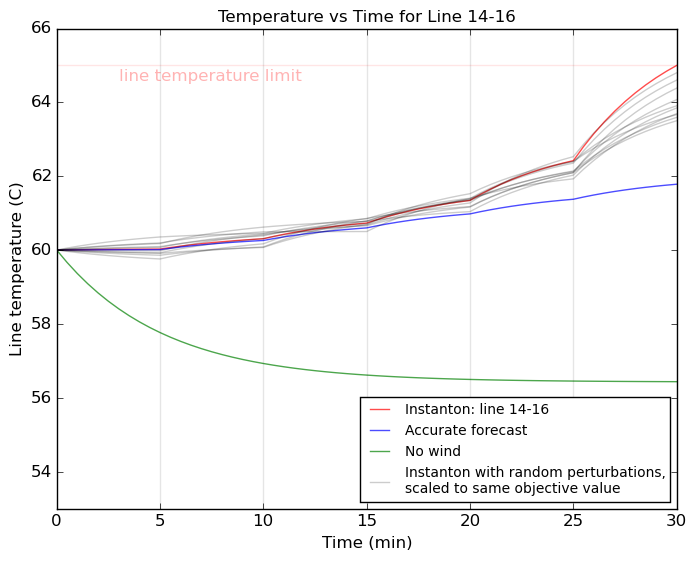

PyObject <matplotlib.text.Text object at 0x7fb9e90f2490>

In [10]:
# Choose event index (1 is instanton):
eidx = 1

# System parameters:
n = length(k)
nr = length(Ridx)
T = int64(length(find(P0))/nr)

# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Line parameters:
idx = find(score.==sort(score)[eidx])[1]
line = lines[line_lengths.!=0][idx]
from,to = line
r_ij = res[line_lengths.!=0][idx]
x_ij = reac[line_lengths.!=0][idx]
L_ij = line_lengths[line_lengths.!=0][idx]

# Generate this many random vectors:
numVecs = 10
vecs = Array(Vector,0)

# First vector is instanton analysis output:
tempVec = Array(FloatingPoint,0)
for i in 1:T
    append!(tempVec,x[idx][i])
end
push!(vecs,tempVec)

# Second vector represents accurate forecast:
push!(vecs,zeros(length(vecs[1])))

# Third vector cancels all wind gen:
push!(vecs,-P0[find(P0)])

# Add a family of vectors with same norm as
# instanton vector:
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5).*(i+1)/35
    # Normalize to match min-score objective:
    traj = sqrt(score[idx])*inter/norm(inter)
    push!(vecs,traj)
end

# Use power flow data and thermal model to compute
# temperature trajectories for each vector:
temp_trajectories = Array(Vector,0)
angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)
for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)

    T0 = 60. #46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end
    push!(temp_trajectories,temp_values)
end

# Plot
fig = figure(figsize=(8,6))
xvals = (0:length(temp_trajectories[1])-1)*time_intervals*int_length/(60*(length(temp_trajectories[1])-1))
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(xvals,temp_trajectories[i],alpha=0.7,"r")
        elseif i == 2
        plot(xvals,temp_trajectories[i],alpha=0.7,"b")
        elseif i == 3
        plot(xvals,temp_trajectories[i],alpha=0.7,"g")
    else
        plot(xvals,temp_trajectories[i],alpha=0.2,"k")
    end
end
title("Temperature vs Time for Line $(from)-$(to)",fontsize=12)
xlabel("Time (min)")
ylabel("Line temperature (C)")
legend(["Instanton: line $(from)-$(to)",
    "Accurate forecast",    
    "No wind",
    "Instanton with random perturbations, \nscaled to same objective value"],fontsize=10,loc=4)
axis([0,30,53,66])
for i in 1:time_intervals
    xval = i*int_length/60
    plot([xval,xval],[40,1.1*Tlim],"k",alpha=0.1)
end
plot([0,30],[Tlim,Tlim],"r",alpha=0.1)
text(3,64.6,"line temperature limit",color="red",alpha=0.3)#color="#FFB2B2")

#savefig("../images/2015-06-24-trajectory_compare3.png", dpi=600)

Results still look correct for this scenario. Awesome.